# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Remark ##

- Code work in progress by Ming-Long
- Based on the BaselineFinal
- Tried log(price) - show QQ-plot
- Tried neural network


In [2]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
import statsmodels.api as sm
import math
import xgboost
from itertools import combinations
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from collections import Counter
%matplotlib inline

In [3]:
#read the data
df = pd.read_csv('listings_clean.csv')
print(df.columns.values)
df.head()

['id' 'host_since' 'zipcode' 'latitude' 'longitude' 'property_type'
 'room_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type'
 'guests_included' 'minimum_nights' 'maximum_nights' 'availability_30'
 'availability_60' 'availability_90' 'availability_365' 'number_of_reviews'
 'first_review' 'last_review' 'review_scores_rating'
 'review_scores_accuracy' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'review_scores_value' 'host_listing_count'
 'price']


,id,host_since,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,1926,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,...,2542.0,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160
1,1846722,1625,NaN,40.830599,-73.941014,0,0,10,1.0,3.0,...,2554.0,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,105
2,2061725,1831,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,...,2554.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58
3,44974,953,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,...,2494.0,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185
4,4701675,2479,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,...,2533.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195


In [4]:
df.shape

(27392, 31)

### Remove 5% samples from smallest zipcode clusters ###

In [5]:
# remove small zipcode clusters, with 95% data left
# count each zipcode entries
nb_counts = Counter(df['zipcode'])
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
# select clusters with size >= 50
tdf1 = tdf[tdf.values>=50]
print 'Remaining data proportion: ' + str(float(sum(tdf1.values))/df.shape[0])
# get zipcode clusters
zipcode_included = tdf1.index

df1 = df.loc[df['zipcode'].isin(zipcode_included)]
print df1.shape

Remaining data proportion: 0.94976635514
(26016, 31)


In [6]:
y = df1['price']

In [7]:
#Feature Extraction:
#Use the features we decided last time
features = ['zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 
            'review_scores_location', 'review_scores_value', 'host_listing_count']

df_x = df1[features]
df_x.head()

,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,1.0,0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
2,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,2.0,0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,1.0,0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,2.0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1
5,11231.0,40.679060,-73.994730,0,0,6,1.0,2.0,3.0,0,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2


Now we start imputing missing values. We fill in numerical values with the mean of its columns, fill in categorical values with most common value of its column.

In [8]:
#categorical and numerical column names
cate = ['zipcode', 'property_type', 'room_type', 'bed_type']
nume = [c for c in df_x.columns.values if c not in cate]

#fill categorical with mode, numerical with mean
df_x_cate = df_x[cate].apply(lambda x:x.fillna(x.value_counts().index[0]))
df_x_nume = df_x[nume].apply(lambda x:x.fillna(x.mean()))

df_x = pd.concat([df_x_cate, df_x_nume], axis=1)
df_x.head()

,zipcode,property_type,room_type,bed_type,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,10022.0,0,0,0,40.756852,-73.964754,2,1.0,1.0,1.0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
2,11221.0,0,1,0,40.692189,-73.924120,2,1.0,1.0,2.0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,10011.0,0,0,0,40.734751,-74.002592,2,1.0,1.0,1.0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,10011.0,0,0,0,40.745282,-73.997836,2,1.0,1.0,2.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1
5,11231.0,0,0,0,40.679060,-73.994730,6,1.0,2.0,3.0,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2


Now we encode categorical variables.

In [9]:
# Get numpy array from data
x = df_x.values

# Apply one hot endcoing
categorical = [(c in cate) for c in df_x.columns]
encoder = preprocessing.OneHotEncoder(categorical_features=categorical, sparse=False)  

x = encoder.fit_transform(x)
x

array([[  0.,   0.,   0., ...,  10.,   9.,   1.],
       [  0.,   0.,   0., ...,   9.,  10.,   4.],
       [  0.,   0.,   0., ...,  10.,   9.,   1.],
       ..., 
       [  0.,   0.,   0., ...,   9.,   8.,  15.],
       [  0.,   0.,   0., ...,   9.,  10.,   7.],
       [  0.,   0.,   0., ...,  10.,  10.,   2.]])

In [10]:
print x.shape
print y.shape

(26016, 103)
(26016,)


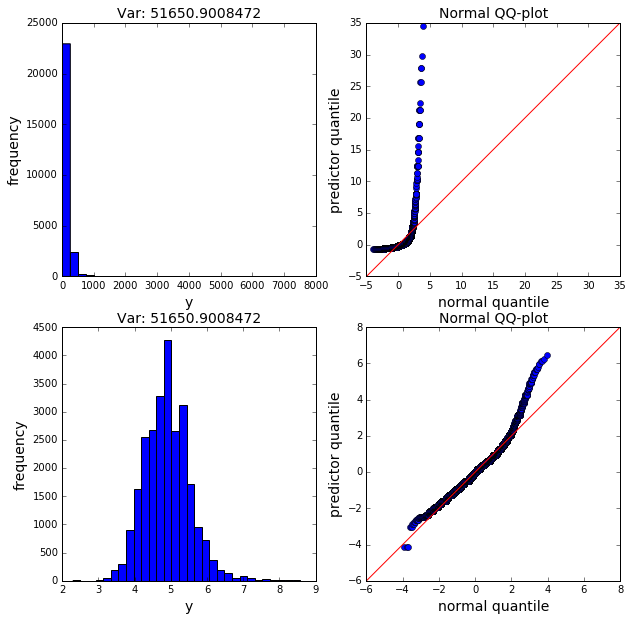

In [11]:
# Check normality of predictors in x_pca
fig3, ax3 = plt.subplots(2, 2, figsize=(10, 10))
# Check y distribution
ax3[0, 0].hist(y, bins = 32, facecolor = 'blue')
ax3[0, 0].set_xlabel('y', fontsize=14)
ax3[0, 0].set_ylabel('frequency', fontsize=14)
ax3[0, 0].set_title('Var: ' + str(np.var(y)), fontsize=14)

sm.qqplot(y,ax=ax3[0, 1], fit=True, line='45')
ax3[0, 1].set_xlabel('normal quantile', fontsize=14)
ax3[0, 1].set_ylabel('predictor quantile', fontsize=14)
ax3[0, 1].set_title('Normal QQ-plot', fontsize=14)

# Check log(y) distribution
ax3[1, 0].hist(np.log(y), bins = 32, facecolor = 'blue')
ax3[1, 0].set_xlabel('y', fontsize=14)
ax3[1, 0].set_ylabel('frequency', fontsize=14)
ax3[1, 0].set_title('Var: ' + str(np.var(y)), fontsize=14)

sm.qqplot(np.log(y),ax=ax3[1, 1], fit=True, line='45')
ax3[1, 1].set_xlabel('normal quantile', fontsize=14)
ax3[1, 1].set_ylabel('predictor quantile', fontsize=14)
ax3[1, 1].set_title('Normal QQ-plot', fontsize=14)


In [12]:
# Transform y with log to make it more symmetric
y_log = np.log(y)

Now we've already preprocessed data in both files. We could start build models. We split our training dataset into train data and test data.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.3, random_state=0)

In [14]:
print 'train data: ', x_train.shape
print 'test data: ', x_test.shape

train data:  (18211, 103)
test data:  (7805, 103)


In [16]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The nltk version is 3.2.1.
The scikit-learn version is 0.17.1.


In [55]:
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [25]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=103, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [26]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)


In [27]:
kfold = KFold(len(x_train),n_folds=10)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


KeyboardInterrupt: 

### Standardize dataset ###

In [ ]:
# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(len(x_train),n_folds=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


### Try a deeper network ###

In [50]:
# define R square score function
def score(in_y_pred, in_y_act):
    
#     in_y_act = in_actual['y'].values
#     in_y_pred = in_predict['y'].values
    in_y_act_mean = in_y_act.mean()
    in_y_pred_mean = in_y_pred.mean()
    
    # input in_predict are an input dataframe
    RSS = np.multiply((in_y_act - in_y_pred), (in_y_act - in_y_pred)).sum()
    TSS = np.multiply((in_y_act - in_y_act_mean), (in_y_act - in_y_act_mean)).sum()
    #
    R_square = 1 - (RSS / TSS)
    
    return R_square

In [80]:
scaler = preprocessing.StandardScaler().fit(x)
x_std = scaler.transform(x)

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_log, test_size=0.3, random_state=0)

In [86]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(103, input_dim=103, init='normal', activation='relu'))
    model.add(Dense(50, init='normal', activation='relu'))
    model.add(Dense(25, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [87]:
time_start=time.time()
model_1=larger_model()
model_1.fit(x_train, y_train, batch_size=10, nb_epoch=100, verbose=0)
time_elapsed=time.time()-time_start
print 'Elasped time: ' + str(time_elapsed)

Elasped time: 419.518140078


In [88]:
y_train_pred=model_1.predict(x_train, batch_size=32, verbose=0)
y_test_pred=model_1.predict(x_test, batch_size=32, verbose=0)

In [43]:
y_train.shape

(18211,)

In [89]:
print score(np.reshape(y_train_pred,(y_train_pred.shape[0],)), y_train)

0.759198976151


In [90]:
print score(np.reshape(y_test_pred,(y_test_pred.shape[0],)), y_test)

0.650077017076


In [30]:
# evaluate model using a deeper network
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, nb_epoch=5, batch_size=10, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(len(x_train),n_folds=10)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Larger: 0.17 (0.02) MSE


In [31]:
pipeline

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x12f2a1c50>)])

## CNN for classification ##

In [18]:
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [20]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=103, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))


In [21]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
# Fit the model
model.fit(x_train, y_train, nb_epoch=150, batch_size=10)


Epoch 1/150
18211/18211 [==============================] - 6s - loss: -57.9950 - acc: 0.0000e+00     
Epoch 2/150
18211/18211 [==============================] - 6s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 3/150
18211/18211 [==============================] - 6s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 4/150
18211/18211 [==============================] - 6s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 5/150
18211/18211 [==============================] - 5s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 6/150
18211/18211 [==============================] - 5s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 7/150
18211/18211 [==============================] - 5s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 8/150
18211/18211 [==============================] - 5s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 9/150
18211/18211 [==============================] - 6s - loss: -62.3075 - acc: 0.0000e+00     
Epoch 10/150
18211/18211 [==============================] - 6s - loss: -62.3075 - 

In [24]:
# evaluate the model
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


7680/7805 [============================>.] - ETA: 0sacc: 0.00%


In [ ]:
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(x_train, y_train)


In [51]:
#OLS
X = sm.add_constant(x_train)
model = sm.OLS(y_train,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     360.7
Date:                Tue, 06 Dec 2016   Prob (F-statistic):               0.00
Time:                        14:30:08   Log-Likelihood:                -7679.2
No. Observations:               18211   AIC:                         1.556e+04
Df Residuals:                   18111   BIC:                         1.634e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -333.9286     28.662    -11.651      0.0

R square is 0.284.  There are some strong multicollinearity problems.

In [52]:
#same OLS model with sklearn (easier to score but less detailed output)
model = LinearRegression()
model.fit(x_train, y_train)
print "Train Score", model.score(x_train, y_train)
print "Test Score", model.score(x_test, y_test)

Train Score 0.663484435695
Test Score 0.659456995631


Interestingly, for this split the test set does better than the training set.

In [54]:
#try several random seeds to check for stability and variance
for r in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.3, random_state=r)
    model = LinearRegression()
    model.fit(x_train, y_train)
    print "Train {:.3f} Test {:.3f}".format(model.score(x_train, y_train), model.score(x_test, y_test))

Train 0.663 Test 0.659
Train 0.660 Test 0.668
Train 0.658 Test 0.672
Train 0.658 Test 0.673
Train 0.657 Test 0.677
Train 0.667 Test 0.652
Train 0.664 Test 0.659
Train 0.666 Test 0.655
Train 0.662 Test 0.663
Train 0.667 Test 0.652


In [55]:
model.coef_

array([  2.41440325e-01,   7.04484144e-02,   2.11267244e-01,
         4.50986058e-02,   1.96923704e-01,   2.00466488e-01,
         1.08696323e-01,   2.58744032e-01,   2.21433681e-01,
         2.50390305e-01,   2.43440383e-01,   2.59369151e-01,
         2.93402077e-01,   2.72060093e-01,   9.01109517e-02,
         1.48403458e-01,   1.59642368e-01,   2.86570058e-01,
         8.88843631e-02,   4.02769837e-02,  -1.02441676e-01,
        -1.77450213e-01,  -3.12881039e-01,   1.56151409e-01,
        -1.37155564e-01,  -3.71559823e-01,  -4.62448875e-01,
        -4.48144358e-01,  -4.89418607e-01,  -5.59794254e-01,
        -2.19996118e-01,   1.72229713e-01,  -1.19633077e-01,
         1.85396913e-01,  -4.42381403e-01,  -5.37627062e-01,
         2.11636012e-01,   1.28757120e-01,   1.59110432e-01,
         2.72530082e-01,  -6.93481277e-01,  -1.00227013e-03,
        -6.21626831e-02,  -3.24971783e-02,  -6.18589978e-02,
        -1.56424267e-01,  -1.11979742e-01,   1.67779700e-01,
         1.88898556e-02,

We check that the coefficients are reasonable (similar in magnitude).  Before we discarded the zipcodes with only a small number of data points, we observed high variance and numerical instability in the coefficents.